In [1]:
import os
import pickle
import numpy as np
import re
import emoji
import regex

def extract_emojis(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

def delete_emojis(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            
            text = re.sub("|".join(word), "", text)

    return text

# load emoji list
fullfile = os.path.expanduser("~/Dropbox/insight/Emoji/"+'mySmileys.p')
with open(fullfile, 'rb') as fp:
    emoji_list = pickle.load(fp)
print(emoji_list)
print(len(emoji_list))

['😀', '😁', '😂', '🤣', '😃', '😄', '😅', '😆', '😉', '😊', '😋', '😎', '😍', '😘', '😗', '😙', '😚', '☺️', '🙂', '🤗', '🤔', '😐', '😑', '😶', '🙄', '😏', '😣', '😥', '😮', '🤐', '😯', '😪', '😫', '😴', '😌', '😛', '😜', '😝', '🤤', '😒', '😓', '😔', '😕', '🙃', '🤑', '😲', '☹️', '🙁', '😖', '😞', '😟', '😤', '😢', '😭', '😦', '😧', '😨', '😩', '😬', '😰', '😱', '😳', '😵', '😡', '😠', '😷', '🤒', '🤕', '🤢', '🤧', '😇', '🤠', '🤡', '🤥', '🤓']
75


## sanitize tweets

In [17]:
def sanitize_tweets(tweet):
    # delete twitter-specific tags
    b1 = re.findall(r'@\S*', tweet) # Twitter user names
    b2 = re.findall(r'RT\S*', tweet) # "RT"
    b3 = re.findall(r'http\S*', tweet) # links
    b4 = re.findall(r'#\S*', tweet) # hashtags

    c = tweet #list(tweet.split())
    for b in b1:
        c = re.sub(re.escape(b),"",c)
    for b in b2:
        c = re.sub(re.escape(b),"",c)
    for b in b3:
        c = re.sub(re.escape(b),"",c)
    for b in b4:
        c = re.sub(re.escape(b),"",c)
    return c
    
tweet = "RT @aa RT @bbb https:__ and other words! #nofilter" #RawT[-1]
sanitize_tweets(tweet)

'     and other words! '

In [91]:
# preprocessing with removing repeat tweets
# IN
target_names = ['😀','🤣','😍','🙄','😛','☹️','😠','🤓'] 
# target_names = ['😍','😡'] #['😍','😩','🙄'] # emoji_list # 

# OUT
rawdata = []
data = []
raw_target = []
Len = []
filenames = []
target_arr = np.zeros((5000*75*2, 75)) # init bigger than actual
search_emoji = []

# main loop
ii = 0
for keyword in target_names:
    print(keyword)
    fullfile = os.path.expanduser("~/Dropbox/insight_datadir/5k/"+'outfile'+keyword+'.p')
    with open(fullfile, 'rb') as fp:
        Tweets1 = pickle.load(fp)
    fullfile = os.path.expanduser("~/Dropbox/insight_datadir/5k_batch2/"+'outfile'+keyword)
    with open(fullfile, 'rb') as fp:
        Tweets2 = pickle.load(fp)
    Tweets = Tweets1+Tweets2

    # remove repeat tweets
    myset = set(Tweets)
    Tweets_unique = list(myset)

    Text = []
    RawText = []
    E = []
    for tweet in Tweets_unique:
        # remove tweets with more than one smiley
        emojis = extract_emojis(tweet)
        a = set(emojis) & set(emoji_list)
        a2 = list(a)
        if len(a2)==1 and a2[0]==keyword: # else: deal with later if doing multi-D target

            # save raw tweet
            RawText.append(tweet)
            # save all emojis from input tweets
            emojis = extract_emojis(tweet)
            E.append(emojis)

    #         # save emojis into target array 
    #         for x in emojis:
    #             if x in emoji_list:
    #                 ix = Edict[x]
    #                 target_arr[ii,ix] = 1

            # save sanitized text
            text = sanitize_tweets(tweet)
            text = delete_emojis(text)
            Text.append(text)
            ii = ii+1

    data = data + Text
    rawdata = rawdata + RawText
    raw_target = raw_target + E
    filenames = filenames + [fullfile]
    search_emoji = search_emoji + [keyword]
    Len.append(len(Text))

😀
🤣
😍
🙄
😛
☹️
😠
🤓


In [92]:
# get 1-D target
numEmojis = len(target_names)
arr = []
for i in range(numEmojis):
    arr.extend([i] * Len[i]) 
target_1d = np.array(arr, dtype=int)

In [93]:
# this struct is saving relatively raw data, for later use ~ visualizations
class tweet_data:
    pass

D = tweet_data()
D.raw_data = rawdata
D.data = data
D.raw_target = raw_target
D.filenames = filenames
D.numTweets = Len
D.target_1d = target_1d
# D.target_arr = target_arr
D.target_names = target_names

In [70]:
# # 10/02
# fullfile = os.path.expanduser("~/Dropbox/insight/Twitter/"+'tweet_data_3x_unique_singles_target1d.p')
# # fullfile = os.path.expanduser("~/Dropbox/insight/Twitter/"+'tweet_data_75x_unique_singles_target1d.p')
# with open(fullfile, 'wb') as fp:
#     pickle.dump(D, fp)

## Train Model

In [94]:
# this is like a struct
class tweet_train:
    pass

T = tweet_train()
T.target_names = target_names
T.data = D.data
T.filenames = D.filenames
T.target = D.target_1d#target

In [95]:
print(T.target_names[T.target[0]])

😀


In [96]:
# Split the dataset in training and test set:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    T.data, T.target, test_size=0.2,random_state=0)

In [99]:
# TASK: Build a vectorizer that splits strings into sequence of 1 to 3
# characters instead of word tokens
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import Perceptron
from sklearn import metrics
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                             use_idf=True, stop_words='english')

XV_train = vectorizer.fit_transform(X_train)

clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='ovr',max_iter=1000) # 'ovr' multinomial
clf.fit(XV_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Test Model

In [100]:
XV_test = vectorizer.transform(X_test)
y_predicted = clf.predict(XV_test)
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=T.target_names))

              precision    recall  f1-score   support

           😀       0.33      0.24      0.28       681
           🤣       0.29      0.08      0.13       514
           😍       0.47      0.48      0.47       915
           🙄       0.30      0.50      0.38      1110
           😛       0.38      0.40      0.39       925
          ☹️       0.45      0.53      0.49      1172
           😠       0.46      0.18      0.26       587
           🤓       0.36      0.34      0.35       902

   micro avg       0.38      0.38      0.38      6806
   macro avg       0.38      0.34      0.34      6806
weighted avg       0.38      0.38      0.37      6806



In [101]:
clf.coef_.shape

(8, 21159)

In [131]:
to_sort = clf.coef_[0]
to_sort.shape

feature_names = vectorizer.get_feature_names()

IX = np.argsort(to_sort)[-50:] # -50: largest values; end of array most representative

# IX = np.argsort(to_sort)[:50] # :50 smallest values


wordsList = []
for ii in range(len(IX)):
    wordsList.append(feature_names[IX[ii]])
print(wordsList)

# ix = wordsList.index("fucking")
# wordsList[ix] = 'f*cking'
# print(wordsList)

['soon', 'winners', 'fellas', 'wishes', 'sir', 'loving', 'huge', 'space', 'live', 'followers', 'brilliant', 'fantastic', 'destiny', 'retweets', 'realme', 'smile', 'strong', 'whoop', 'sunday', 'friday', 'stream', 'pleasure', 'worry', 'weekend', 'smiling', 'win', 'followed', 'indianapolis', 'yay', 'whatsapp', 'happy', 'thanks', 'sweet', 'bless', 'thank', 'good', 'awesome', 'forward', 'hi', 'debut', 'follower', 'wonderful', 'enjoy', 'nice', 'hello', 'congratulations', 'welcome', 'glad', 'fun', 'great']


In [83]:
np.sort(to_sort)[-50:]

array([1.3425158 , 1.34334238, 1.34955848, 1.35221931, 1.35675016,
       1.36614837, 1.3888618 , 1.40540002, 1.4103247 , 1.42264211,
       1.43675201, 1.44691036, 1.45049511, 1.45516015, 1.47010155,
       1.47019753, 1.4730271 , 1.49718195, 1.50536279, 1.50838141,
       1.50841594, 1.51242967, 1.53009896, 1.53135618, 1.56479044,
       1.59779011, 1.60127356, 1.61027856, 1.63580266, 1.63679531,
       1.68207639, 1.70927589, 1.72026883, 1.73539012, 1.73871243,
       1.74854732, 1.76366504, 1.78728604, 1.79947944, 1.82915303,
       1.86954169, 1.96265631, 1.96313172, 1.96568359, 1.97115688,
       1.97530025, 2.31002151, 2.37595483, 2.44397694, 3.07071166])

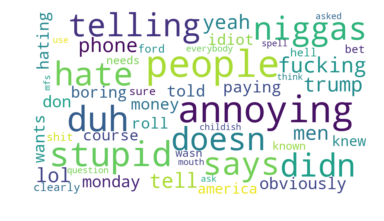

In [90]:
# make word cloud input
K = wordsList
V = abs(np.sort(to_sort)[-50:])
# V = abs(np.sort(to_sort)[:50])
d = {}
for ii in range(50):
    k = K[ii]
    v = V[ii]
    d[k] = v
    
# wordcloud = WordCloud(background_color="white",width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(d)
wordcloud = WordCloud(background_color="white",width=900,height=500,max_font_size=100).generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# wordcloud.to_file("eye_roll_words.png")

In [144]:
test0 = ['site for meet teen friends and love.','Pigeons As Pets: Outside or Indoors Do the pigeons need to be of the same breed of pigeon? ...... which they were staying now i kept it in my balcony, both the pigeon flu away will they come back?']
# test0 = ['What are your worst experiences with house centipedes Quora we deal with Tiger Centipedes(Scolopendra Polymorpha) and they usually come ... Whole House stinks really bad for a couple of Hours after a Spray down.']
xv_test = vectorizer.transform(test0)
print(xv_test.shape)
y_predicted = clf.predict(xv_test)
y_probs = clf.predict_proba(xv_test)
print(y_probs)
print(y_predicted[0])
T.target_names[y_predicted[0]]

(2, 21159)
[[0.08359024 0.03479959 0.23037363 0.05568677 0.13817456 0.28863854
  0.02866545 0.14007121]
 [0.04819003 0.06413683 0.07110569 0.25401942 0.09095753 0.23789076
  0.15259054 0.0811092 ]]
5


'☹️'

array([5])

In [135]:
# save model
# fullfile = os.path.expanduser("~/Dropbox/insight_datadir/"+'clf_2step_75way_1002_mindf6.p')
fullfile = os.path.expanduser("~/Dropbox/insight_datadir/"+'clf_2step_8way_1009.p')
with open(fullfile, 'wb') as fp:
    pickle.dump([vectorizer,clf], fp)

In [136]:
y_train.max()

7